# Model evaluation with ROC AUC

In [89]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [90]:
# data preparation

df = pd.read_csv("churn.csv")

df.columns = df.columns.str.lower().str.replace(" ", "_")
categorical_columns = list(df.dtypes[df.dtypes == "object"].index)
for c in categorical_columns:
    df[c] = df[c].str.lower().str.replace(" ", "_")
df.totalcharges = pd.to_numeric(df.totalcharges, errors="coerce")
df.totalcharges = df.totalcharges.fillna(0)
df.churn = (df.churn == "yes").astype(int)

In [91]:
df.head(1)

,customerid,gender,seniorcitizen,partner,dependents,tenure,phoneservice,multiplelines,internetservice,onlinesecurity,...,deviceprotection,techsupport,streamingtv,streamingmovies,contract,paperlessbilling,paymentmethod,monthlycharges,totalcharges,churn
0,7590-vhveg,female,0,yes,no,1,no,no_phone_service,dsl,no,...,no,no,no,no,month-to-month,yes,electronic_check,29.85,29.85,0


In [92]:
from sklearn.model_selection import train_test_split

df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.churn.values
y_val = df_val.churn.values
y_test = df_test.churn.values

del df_train["churn"]
del df_val["churn"]
del df_test["churn"]

# note that df_full_train still contains the target variable
# this set will be later used for k-fold cross-validation

In [93]:
print(f"train shape: {df_train.shape}")
print(f"val shape: {df_val.shape}")
print(f"test shape: {df_test.shape}")
print(f"full train shape: {df_full_train.shape}")

train shape: (4225, 20)
val shape: (1409, 20)
test shape: (1409, 20)
full train shape: (5634, 21)


In [94]:
numerical = ["tenure", "monthlycharges", "totalcharges"]

categorical = [
    "gender",
    "seniorcitizen",
    "partner",
    "dependents",
    "phoneservice",
    "multiplelines",
    "internetservice",
    "onlinesecurity",
    "onlinebackup",
    "deviceprotection",
    "techsupport",
    "streamingtv",
    "streamingmovies",
    "contract",
    "paperlessbilling",
    "paymentmethod",
]

In [95]:
# convert dataframes to one-hot encoding mixed with numericals

from sklearn.feature_extraction import DictVectorizer

dv = DictVectorizer(sparse=False)

train_dict = df_train[categorical + numerical].to_dict(orient="records")
dv.fit(train_dict)
X_train = dv.transform(train_dict)
X_val = dv.transform(df_val[categorical + numerical].to_dict(orient="records"))

In [96]:
# train a reference model - no hyperparameter tuning

from sklearn.linear_model import LogisticRegression

reference_model = LogisticRegression(max_iter=20_000)
reference_model.fit(X_train, y_train)

LogisticRegression(max_iter=20000)

## Reference model accuracy

In [97]:
y_prob = reference_model.predict_proba(X_val) # pairwise neg / pos
y_pred = y_prob[:, 1] # positive class probability
y_decision = y_pred >= 0.5 # ref threshold

# calculate accuracy manually

acc = (y_val == y_decision).mean()
print(f"ref model accuracy = {acc:.3f} on {len(X_val)} samples")

ref model accuracy = 0.804 on 1409 samples


In [98]:
# distribution of pos / neg in validation data

print(f"positive class rate in validation data = {y_val.mean():.3f}")

positive class rate in validation data = 0.274


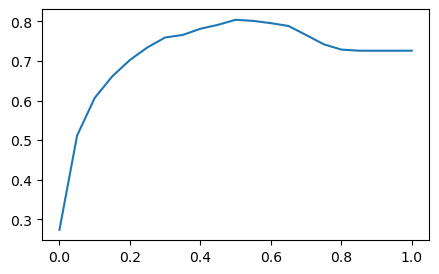

In [99]:
# dependency of accuracy on threshold

thresholds = np.linspace(0, 1, 21)

acc_scores = []
for t in thresholds:
    y_decision = y_pred >= t
    acc = (y_val == y_decision).mean()
    acc_scores.append(acc)

plt.subplots(figsize=(5, 3))
plt.plot(thresholds, acc_scores, label="accuracy")

## Confusion matrix

Building manually in Numpy

In [100]:
all_pos = (y_val == 1)
all_neg = (y_val == 0)
pred_pos = (y_pred >= 0.5)
pred_neg = (y_pred < 0.5)
true_pos = (all_pos & pred_pos)
true_neg = (all_neg & pred_neg)
false_pos = (all_neg & pred_pos)
false_neg = (all_pos & pred_neg)

cm = np.array([
    [true_neg.sum(), false_neg.sum()],
    [false_pos.sum(), true_pos.sum()]
])

print(cm) # predicted are down, actual are across
print((cm / cm.sum()).round(2)) # diagonal sum is accuracy

[[921 174]
 [102 212]]
[[0.65 0.12]
 [0.07 0.15]]


In [101]:
# or use a shortcut!
# but note that sklearn uses a different convention for confusion matrix
# the axes are swapped
# actuals are down, predictions are across

from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_val, y_pred >= 0.5)
print(cm)
print(cm.T)

[[921 102]
 [174 212]]
[[921 174]
 [102 212]]


## Precision and recall

In [102]:
# precision is the number of correctly flagged positives

prec = true_pos.sum() / (true_pos.sum() + false_pos.sum())
print(f"precision = {prec:.3f}")

precision = 0.675


In [103]:
# recall is the number of detected positives

rec = true_pos.sum() / (true_pos.sum() + false_neg.sum())
print(f"recall = {rec:.3f}")

recall = 0.549


In [104]:
# using sklearn

from sklearn.metrics import precision_score, recall_score

prec = precision_score(y_val, y_pred >= 0.5)
print(f"precision = {prec:.3f}")

rec = recall_score(y_val, y_pred >= 0.5)
print(f"recall = {rec:.3f}")

precision = 0.675
recall = 0.549


In [105]:
# f1 score is the harmonic mean of precision and recall
# it's a special case of F-beta score with beta = 1

f1 = 2 * (prec * rec) / (prec + rec)
print(f"f1 = {f1:.3f}")

f1 = 0.606


## P/R versus thresholds

Verify precision and recall for different cutoff thresholds

In [106]:
# compute tp, fp, fn, tn for all thresholds

thresholds = np.linspace(0, 1, 101)

scores = []
for t in thresholds:
    y_decision = y_pred >= t
    tp = (y_val == 1) & (y_decision == 1)
    fp = (y_val == 0) & (y_decision == 1)
    fn = (y_val == 1) & (y_decision == 0)
    tn = (y_val == 0) & (y_decision == 0)
    scores.append((t, tp.sum(), fp.sum(), fn.sum(), tn.sum()))

In [107]:
# convert into dataframe for convenience

columns = ["threshold", "tp", "fp", "fn", "tn"]
ref_df_scores = pd.DataFrame(scores, columns=columns)

# show distribution of tp, fp, fn, tn with 10 steps

ref_df_scores[::10]

,threshold,tp,fp,fn,tn
0,0.0,386,1023,0,0
10,0.1,366,534,20,489
20,0.2,339,372,47,651
30,0.3,292,245,94,778
40,0.4,253,175,133,848
50,0.5,212,102,174,921
60,0.6,151,53,235,970
70,0.7,69,13,317,1010
80,0.8,4,0,382,1023
90,0.9,0,0,386,1023


In [108]:
# calculate fpr, tpr for all thresholds
# fpr is the ratio of fps to all negatives ("false alarm rate")
# tpr is the ratio of tps to all positives (equals recall)

ref_df_scores["fpr"] = (ref_df_scores.fp / (ref_df_scores.fp + ref_df_scores.tn).round(4))
ref_df_scores["tpr"] = (ref_df_scores.tp / (ref_df_scores.tp + ref_df_scores.fn)).round(4)

ref_df_scores[::10]

,threshold,tp,fp,fn,tn,fpr,tpr
0,0.0,386,1023,0,0,1.000000,1.0000
10,0.1,366,534,20,489,0.521994,0.9482
20,0.2,339,372,47,651,0.363636,0.8782
30,0.3,292,245,94,778,0.239492,0.7565
40,0.4,253,175,133,848,0.171065,0.6554
50,0.5,212,102,174,921,0.099707,0.5492
60,0.6,151,53,235,970,0.051808,0.3912
70,0.7,69,13,317,1010,0.012708,0.1788
80,0.8,4,0,382,1023,0.000000,0.0104
90,0.9,0,0,386,1023,0.000000,0.0000


## ROC intuition

By starting from t=0 and moving threshold upwards we start to capture more and more positives. Initially they will be mostly true but as threshold moves lower there will be more and more false detections.

The optimization problem is to find the threshold where tradeoff is still acceptable for given use case.

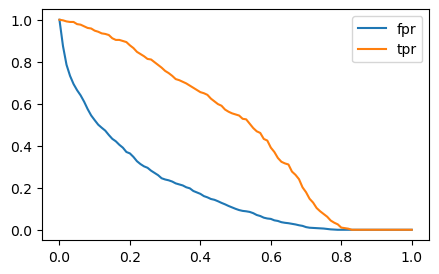

In [109]:
# plotting FPR and TPR separately - for all thresholds

plt.subplots(figsize=(5, 3))
plt.plot(ref_df_scores.threshold, ref_df_scores.fpr, label="fpr")
plt.plot(ref_df_scores.threshold, ref_df_scores.tpr, label="tpr")
plt.legend()

## Plotting FPR / TPR for random classifier

Relationship between FPR and TPR for a model that predicts using a uniform distribution.

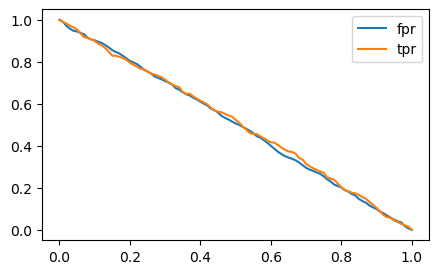

In [110]:
# random classifier generates len(y_val) random numbers from uniform distribution

np.random.seed(1)
y_rand = np.random.uniform(0, 1, len(y_val))

# calculate fpr, tpr for random classifier

scores = []

for t in thresholds:
    y_decision = y_rand >= t
    tp = (y_val == 1) & (y_decision == 1)
    fp = (y_val == 0) & (y_decision == 1)
    fn = (y_val == 1) & (y_decision == 0)
    tn = (y_val == 0) & (y_decision == 0)
    scores.append((t, tp.sum(), fp.sum(), fn.sum(), tn.sum()))

# convert into dataframe for convenience

columns = ["threshold", "tp", "fp", "fn", "tn"]
rand_df_scores = pd.DataFrame(scores, columns=columns)

rand_df_scores["fpr"] = (rand_df_scores.fp / (rand_df_scores.fp + rand_df_scores.tn).round(4))
rand_df_scores["tpr"] = (rand_df_scores.tp / (rand_df_scores.tp + rand_df_scores.fn)).round(4)

plt.subplots(figsize=(5, 3))
plt.plot(rand_df_scores.threshold, rand_df_scores.fpr, label="fpr")
plt.plot(rand_df_scores.threshold, rand_df_scores.tpr, label="tpr")
plt.legend()

## Plotting FPR / TPR for perfect classifier

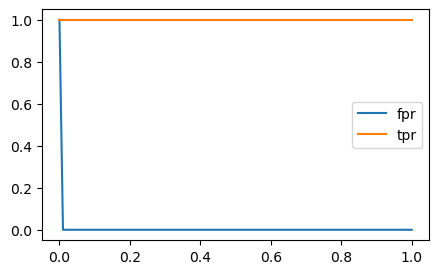

In [111]:
y_perf = y_val

scores = []

for t in thresholds:
    y_decision = y_perf >= t
    tp = (y_val == 1) & (y_decision == 1)
    fp = (y_val == 0) & (y_decision == 1)
    fn = (y_val == 1) & (y_decision == 0)
    tn = (y_val == 0) & (y_decision == 0)
    scores.append((t, tp.sum(), fp.sum(), fn.sum(), tn.sum()))

# convert into dataframe for convenience

columns = ["threshold", "tp", "fp", "fn", "tn"]
perf_df_scores = pd.DataFrame(scores, columns=columns)

perf_df_scores["fpr"] = (perf_df_scores.fp / (perf_df_scores.fp + perf_df_scores.tn).round(4))
perf_df_scores["tpr"] = (perf_df_scores.tp / (perf_df_scores.tp + perf_df_scores.fn)).round(4)

plt.subplots(figsize=(5, 3))
plt.plot(perf_df_scores.threshold, perf_df_scores.fpr, label="fpr")
plt.plot(perf_df_scores.threshold, perf_df_scores.tpr, label="tpr")
plt.legend()

## ROC curve

Plotting x=FPR against y=TPR produces a ROC tradeoff curve.

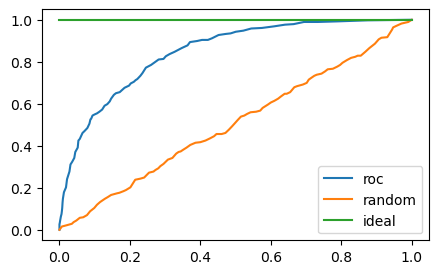

In [112]:
# ROC comparison for all models

plt.subplots(figsize=(5, 3))
plt.plot(ref_df_scores.fpr, ref_df_scores.tpr, label="roc")
plt.plot(rand_df_scores.fpr, rand_df_scores.tpr, label="random")
plt.plot(perf_df_scores.fpr, perf_df_scores.tpr, label="ideal")
plt.legend()

## AUC score

Area under ROC curve is the probability of randomly selected positive sample having higher proba than randomly selected negative sample.

For perfect classifier it's obviously 100%.

For random classifier it's equivalent to coin toss.

Maximize ROC AUC to select best model from family.

In [113]:
from sklearn.metrics import roc_auc_score, auc, roc_curve

In [114]:
auc_model = auc(ref_df_scores.fpr, ref_df_scores.tpr)
auc_rand = auc(rand_df_scores.fpr, rand_df_scores.tpr)
auc_perf = auc(perf_df_scores.fpr, perf_df_scores.tpr)
print(f"model auc = {auc_model:.3f}")
print(f"rand auc = {auc_rand:.3f}")
print(f"perf auc = {auc_perf:.3f}")

model auc = 0.846
rand auc = 0.506
perf auc = 1.000


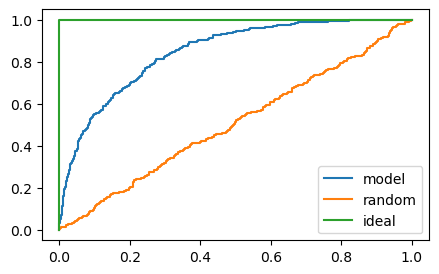

In [115]:
# roc curve method returns fpr, tpr, thresholds as triplet

ref_curve = roc_curve(y_val, y_pred)
rand_curve = roc_curve(y_val, y_rand)
perf_curve = roc_curve(y_val, y_val)

plt.subplots(figsize=(5, 3))
plt.plot(ref_curve[0], ref_curve[1], label="model")
plt.plot(rand_curve[0], rand_curve[1], label="random")
plt.plot(perf_curve[0], perf_curve[1], label="ideal")
plt.legend()

In [116]:
roc_auc_score(y_val, y_pred) # same as auc but different internals

np.float64(0.8463145579140898)

## Crossvalidation and parameter tuning

In [117]:
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
import tqdm

In [118]:
y_train

array([0, 0, 1, ..., 1, 0, 1])

In [133]:
def train(X: pd.DataFrame, y: np.array, C: float) -> tuple[DictVectorizer, LogisticRegression]:
    """Train logistic regression model with regularization parameter C."""
    dv = DictVectorizer(sparse=False)
    X_dict = X[numerical + categorical].to_dict(orient="records")
    X = dv.fit_transform(X_dict)
    model = LogisticRegression(C=C, max_iter=20_000)
    model.fit(X, y)
    return dv, model

def predict(X: pd.DataFrame, dv: DictVectorizer, model: LogisticRegression) -> np.array:
    """Predict using a pretrained model. Return positive class probabilities."""
    X_dict = X.to_dict(orient="records")
    X = dv.transform(X_dict)
    y_pred = model.predict_proba(X)[:, 1] # positive class probs
    return y_pred

In [120]:
kfold = KFold(n_splits=5, shuffle=True)

# kfold split returns a generator
# each iter will yield a (train_idx, val_dx) tuple
# returned values are indices only - do the split manually

res = next(iter(kfold.split(df_full_train)))
res

(array([   0,    1,    2, ..., 5630, 5631, 5632]),
 array([  15,   39,   42, ..., 5627, 5629, 5633]))

In [138]:
from tqdm import tqdm
from sklearn.metrics import accuracy_score

scores = []
for _ in tqdm(range(5)):
    train_idx, val_idx = next(kfold.split(df_full_train))
    X_train = df_full_train.iloc[train_idx].copy()
    y_train = df_full_train.iloc[train_idx].churn.values
    X_val = df_full_train.iloc[val_idx].copy()
    y_val = df_full_train.iloc[val_idx].churn.values
    dv, model = train(X_train, y_train, C=1.0)
    preds = predict(X_val, dv, model)
    y_pred = preds >= 0.5
    acc = accuracy_score(y_val, y_pred)
    auc = roc_auc_score(y_val, preds) # insert probabilities, not classes
    scores.append((acc, auc))

scores # mean & stdev on kfold can be used to assert model stability

100%|██████████| 5/5 [00:01<00:00,  2.55it/s]


[(0.7914818101153505, np.float64(0.8415140664551892)),
 (0.8021295474711624, np.float64(0.8289493668862314)),
 (0.7950310559006211, np.float64(0.8301859060935887)),
 (0.7905944986690329, np.float64(0.8548409082057872)),
 (0.8110026619343389, np.float64(0.8427718025985904))]

In [142]:
c_params = [0.001, 0.01, 0.1, 0.5, 1, 5, 10, 100]

res = dict()
splits = 10
for c in tqdm(c_params):
    scores = []
    for _ in range(splits):
        train_i, val_i = next(kfold.split(df_full_train))
        X_train = df_full_train.iloc[train_i].copy()
        y_train = df_full_train.iloc[train_i].churn.values
        X_val = df_full_train.iloc[val_i].copy()
        y_val = df_full_train.iloc[val_i].churn.values
        dv, model = train(X_train, y_train, C=c)
        probs = predict(X_val, dv, model)
        roc = roc_auc_score(y_val, probs)
        scores.append(roc)
    res.update({c: [np.mean(scores).round(3), np.std(scores).round(3)]})

res

100%|██████████| 8/8 [00:29<00:00,  3.67s/it]


{0.001: [np.float64(0.825), np.float64(0.012)],
 0.01: [np.float64(0.838), np.float64(0.008)],
 0.1: [np.float64(0.84), np.float64(0.013)],
 0.5: [np.float64(0.845), np.float64(0.009)],
 1: [np.float64(0.838), np.float64(0.009)],
 5: [np.float64(0.839), np.float64(0.01)],
 10: [np.float64(0.846), np.float64(0.015)],
 100: [np.float64(0.843), np.float64(0.008)]}